## Problem 3: Read before you buy!

![zillow](zillow.png)

### Overview of the problem

Here we have a dataset of single family houses sold in Connecticut near the beginning of 2021, collected from [Zillow](https://www.zillow.com/homes/connecticut_rb/). You will build linear models of the price at which each house sold for, based on its characteristics listed in the real estate listing. Such characteristics include internal square footage, the year it was built, the bedroom count, the bathroom count, and the area of the lot. 

But there is also usually a lengthy description written by the real estate agent. Is there any additional information hidden in such a description that would help improve the model of the price? This is the question we focus on in this problem.

Answering such a question is difficult because the description is written in natural language with thousands of different words. Here we use topic models as a dimension reduction technique. Specifically, instead of using thousands of possible words, and how many times they show up in each house description, we reduce the words to the topic proportions $\theta_d$ for each document, obtained by posterior inference. These proportions are combined with the other quantitative variables in a linear model with the logarithm of the house price as the response variable. 

Acknowledgment: The data were scraped and the analysis was done by [Parker Holzer](https://parkerholzer.github.io/), as he began his search for a new house for his family after beginning a job as a data scientist. Thanks Parker!


In [1]:
import numpy as np
import pandas as pd
import re
import gensim
from collections import Counter
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

### Read in and clean up the data

In [2]:
ct_homes = pd.read_csv('ct_zillow.csv')
ct_homes

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0
...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0


#### Transform the data

1. Add columns to `ct_homes` called `logAREA`, `logLOTSIZE`, and `logPRICE` that take the logarithms of the corresponding columns in the original data. 

1. Show histograms of each of the resulting columns.

1. Our regression models will use these transformed values. Why might it be preferable to use the logarithms rather than the original data?


In [3]:
ct_homes['logAREA'] = np.log(ct_homes['AREA'])
ct_homes['logLOTSIZE'] = np.log(ct_homes['LOTSIZE'])
ct_homes['logPRICE'] = np.log(ct_homes['PRICE'])
ct_homes

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE,logAREA,logLOTSIZE,logPRICE
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0,7.395722,-1.832669,12.319401
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0,7.153052,-1.714902,12.323856
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0,7.142037,-2.408049,12.323411
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0,7.627544,-0.562129,12.821258
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0,8.342364,-0.061887,13.102159
...,...,...,...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0,6.742881,-1.660781,12.971308
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0,7.783224,-2.525960,13.592367
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0,8.785387,-2.525960,14.808762
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0,8.407378,-0.162521,14.751604


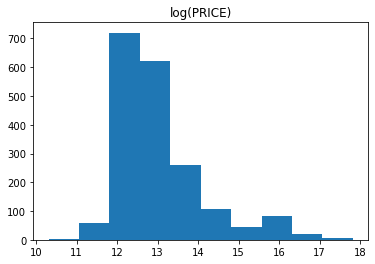

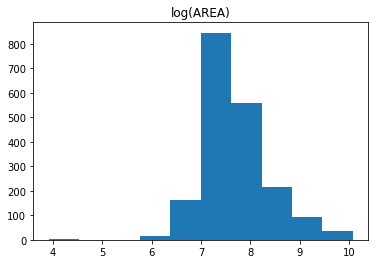

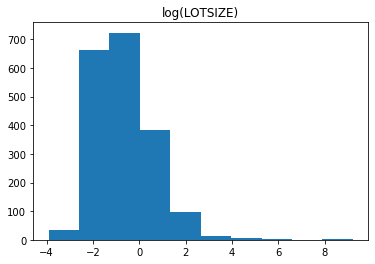

In [4]:
plt.hist(ct_homes['logPRICE'])
plt.title('log(PRICE)')
plt.show()
plt.hist(ct_homes['logAREA'])
plt.title('log(AREA)')
plt.show()
plt.hist(ct_homes['logLOTSIZE'])
plt.title('log(LOTSIZE)')
plt.show()

#### Let's look at one of the descriptions as an example.

In [5]:
example = 9
ct_homes["DESCRIPTION"][example]

"One of Ridgefield's most admired homes, custom built with absolutely no expense spared. Stunning Stone and Clapboard New England Colonial with exceptional architectural details throughout, beautifully sited on 1.48 park-like acres. The heart of this home features an updated gourmet Kitchen with Dacor double ovens, Viking cook top and Sub Zero Refrigerator. Gorgeous Taj Mahal Quartz counters and island with Tumbled Limestone back splash. Stylish Living Room with propane fireplace and spacious Dining Room with large Butler's pantry also with quartz and tumbled marble. Handsome Cherry paneled Library and sun filled Family Room with fireplace and built-in cabinets and desk. The Upper level features a large Master Suite with custom marble bath and generous walk-in closet. Three Bedrooms are en suite; and two bedrooms share a lovely Jack n Jill Bathroom. Large, custom Laundry Room and over sized Bonus Room round out the second floor. Other convenient features include front and rear staircas

#### Helper functions

The following two functions will be used to clean up the text a bit and separate into tokens

In [6]:
def cleanup_description(desc):
    if type(desc) == float:
        desc = ""
    words = [re.sub(r'[^a-z]', '', w) for w in desc.lower().split(' ')]
    return ' '.join(words)

def reduce_to_vocabulary(desc, vocab):
    return ' '.join([w for w in cleanup_description(desc).split(' ') if w in vocab])


In [7]:
cleanup_description(ct_homes['DESCRIPTION'][example])

'one of ridgefields most admired homes custom built with absolutely no expense spared stunning stone and clapboard new england colonial with exceptional architectural details throughout beautifully sited on  parklike acres the heart of this home features an updated gourmet kitchen with dacor double ovens viking cook top and sub zero refrigerator gorgeous taj mahal quartz counters and island with tumbled limestone back splash stylish living room with propane fireplace and spacious dining room with large butlers pantry also with quartz and tumbled marble handsome cherry paneled library and sun filled family room with fireplace and builtin cabinets and desk the upper level features a large master suite with custom marble bath and generous walkin closet three bedrooms are en suite and two bedrooms share a lovely jack n jill bathroom large custom laundry room and over sized bonus room round out the second floor other convenient features include front and rear staircases mud room with builti

#### Count how many times each word occurs 

In [8]:
vocab = Counter()
for dsc in ct_homes['DESCRIPTION']:
    vocab.update(cleanup_description(dsc).split(' '))


In [9]:
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 9738


#### Remove words that are either too common or too rare

In [10]:
vocab = Counter(token for token in vocab.elements() if vocab[token] > 5)
stop_words = [item[0] for item in vocab.most_common(50)]
vocab = Counter(token for token in vocab.elements() if token not in stop_words)
print("Number of unique tokens: %d" % len(vocab))

Number of unique tokens: 2540


#### Build a mapping between unique words and integers

In [11]:
desc = ct_homes['DESCRIPTION'][example]
print('Original description:\n---------------------')
print(desc)

print('\nCleaned up text:\n----------------')
print(cleanup_description(desc))

print('\nReduced to vocabulary:\n----------------------')
print(reduce_to_vocabulary(desc, vocab))

Original description:
---------------------
One of Ridgefield's most admired homes, custom built with absolutely no expense spared. Stunning Stone and Clapboard New England Colonial with exceptional architectural details throughout, beautifully sited on 1.48 park-like acres. The heart of this home features an updated gourmet Kitchen with Dacor double ovens, Viking cook top and Sub Zero Refrigerator. Gorgeous Taj Mahal Quartz counters and island with Tumbled Limestone back splash. Stylish Living Room with propane fireplace and spacious Dining Room with large Butler's pantry also with quartz and tumbled marble. Handsome Cherry paneled Library and sun filled Family Room with fireplace and built-in cabinets and desk. The Upper level features a large Master Suite with custom marble bath and generous walk-in closet. Three Bedrooms are en suite; and two bedrooms share a lovely Jack n Jill Bathroom. Large, custom Laundry Room and over sized Bonus Room round out the second floor. Other convenie

#### Build a mapping between unique words and integers

In [12]:
id2word = {idx: pair[0] for idx, pair in enumerate(vocab.items())}
word2id = {pair[0]: idx for idx, pair in enumerate(vocab.items())}

s = 'nyc'
print("Number of tokens mapped: %d" % len(id2word))
print("Identifier for '%s': %d" % (s,word2id[s]))
print("Word for identifier %d: %s" % (word2id[s], id2word[word2id[s]]))

Number of tokens mapped: 2540
Identifier for 'nyc': 477
Word for identifier 477: nyc


#### Map to word id format

Now, use the format required to build a language model, mapping each word to its id, 

In [13]:
tokens = []
for dsc in ct_homes['DESCRIPTION']:
    clean = reduce_to_vocabulary(cleanup_description(dsc), vocab)
    toks = clean.split(' ')
    tokens.append(toks)

In [14]:
corpus = []
for toks in tokens:
    tkn_count = Counter(toks)
    corpus.append([(word2id[item[0]], item[1]) for item in tkn_count.items()])
    
dsc = ct_homes['DESCRIPTION'][example]
clean = reduce_to_vocabulary(cleanup_description(dsc), vocab)
toks = clean.split(' ')
print("Abstract, tokenized:\n", toks, "\n")
print("Abstract, in corpus format:\n", corpus[10])

Abstract, tokenized:
 ['one', 'most', 'homes', 'custom', 'built', 'absolutely', 'no', 'expense', 'spared', 'stunning', 'stone', 'clapboard', 'england', 'colonial', 'exceptional', 'architectural', 'details', 'throughout', 'beautifully', 'sited', 'parklike', 'acres', 'heart', 'updated', 'gourmet', 'dacor', 'double', 'ovens', 'viking', 'cook', 'top', 'sub', 'refrigerator', 'gorgeous', 'quartz', 'counters', 'island', 'limestone', 'back', 'splash', 'stylish', 'propane', 'spacious', 'butlers', 'pantry', 'also', 'quartz', 'marble', 'handsome', 'cherry', 'paneled', 'library', 'sun', 'filled', 'builtin', 'cabinets', 'desk', 'upper', 'suite', 'custom', 'marble', 'generous', 'walkin', 'closet', 'three', 'are', 'en', 'suite', 'two', 'share', 'lovely', 'jack', 'n', 'jill', 'bathroom', 'custom', 'laundry', 'over', 'sized', 'bonus', 'round', 'out', 'second', 'other', 'convenient', 'include', 'front', 'rear', 'staircases', 'mud', 'builtins', 'pantry', 'utility', 'closets', 'finished', 'lower', 'second

#### Build a Topic Model with 10 topics

In [15]:
%%time
tm = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=10, 
                                     random_state=100,
                                     update_every=1,
                                     chunksize=100,
                                     passes=10,
                                     alpha='auto',
                                     per_word_topics=True)

CPU times: user 5.18 s, sys: 10.3 ms, total: 5.19 s
Wall time: 5.19 s


In [16]:
num_topics = 10
num_words = 15
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = tm.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words

,word rank,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,1,create,property,spacious,waterfront,north,will,beach,guests,farm,custom
1,2,architect,it,additional,ft,boasts,roof,water,solar,farmhouse,suite
2,3,premier,own,main,sq,provides,well,sound,panels,antique,island
3,4,indoor,location,perfect,milford,state,have,views,rock,cheshire,by
4,5,shaker,at,bathroom,unique,morning,newer,long,metro,trees,pool
5,6,kayaks,can,two,built,fire,one,miles,salt,better,views
6,7,acreage,opportunity,lower,construction,many,water,post,masterpiece,association,stone
7,8,restored,close,finished,if,garden,been,steps,energy,chestnut,built
8,9,beginning,town,throughout,yale,work,by,directly,amp,original,ceilings
9,10,ny,come,beautiful,barn,coffee,ranch,across,service,historic,stunning


In [17]:
topic_dist = tm.get_document_topics(corpus[example])
topics = [pair[0] for pair in topic_dist]
probabilities = [pair[1] for pair in topic_dist]
topic_dist_table = pd.DataFrame()
topic_dist_table['Topic'] = topics
topic_dist_table['Probabilities'] = probabilities
topic_dist_table

,Topic,Probabilities
0,1,0.044947
1,2,0.308954
2,3,0.013631
3,4,0.014789
4,5,0.034339
5,9,0.568488


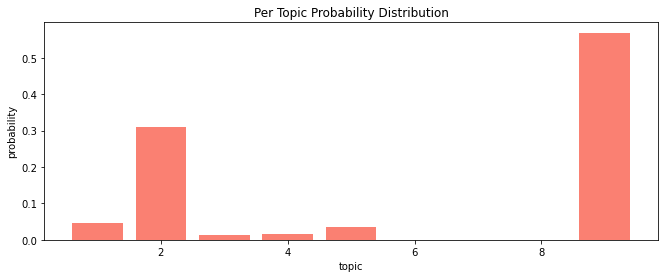

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(11,4)
plt.bar(topic_dist_table['Topic'], topic_dist_table['Probabilities'], align='center', alpha=1, color='salmon')
plt.xlabel('topic')
plt.ylabel('probability')
plt.title('Per Topic Probability Distribution')
plt.show()

### Include the topic proportions $\theta_d$ for each house 


In [19]:
num_topics = 10
theta = pd.DataFrame({"Theta0": np.zeros(ct_homes.shape[0])})
for t in np.arange(1,num_topics):
    theta["Theta"+str(t)] = np.zeros(ct_homes.shape[0])
    
for i in np.arange(ct_homes.shape[0]):
    for t in tm.get_document_topics(corpus[i]):
        theta.loc[i,"Theta"+str(t[0])] = t[1]

In [20]:
ct_topics = ct_homes.join(theta)
ct_topics

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE,logAREA,logLOTSIZE,logPRICE,Theta0,Theta1,Theta2,Theta3,Theta4,Theta5,Theta6,Theta7,Theta8,Theta9
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0,7.395722,-1.832669,12.319401,0.000000,0.217733,0.307562,0.013004,0.015983,0.276442,0.000000,0.068734,0.0,0.090220
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0,7.153052,-1.714902,12.323856,0.058219,0.071380,0.402322,0.012686,0.015575,0.241167,0.000000,0.132528,0.0,0.056359
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0,7.142037,-2.408049,12.323411,0.000000,0.585883,0.156176,0.010631,0.016617,0.139862,0.033774,0.019388,0.0,0.030921
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0,7.627544,-0.562129,12.821258,0.018890,0.024961,0.828650,0.000000,0.010880,0.073783,0.000000,0.000000,0.0,0.030548
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0,8.342364,-0.061887,13.102159,0.000000,0.066090,0.488583,0.000000,0.036448,0.311833,0.000000,0.000000,0.0,0.076273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0,6.742881,-1.660781,12.971308,0.019154,0.141276,0.446501,0.026240,0.028841,0.262198,0.000000,0.018545,0.0,0.048959
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0,7.783224,-2.525960,13.592367,0.025282,0.041325,0.539177,0.015924,0.059542,0.115156,0.075165,0.000000,0.0,0.118586
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0,8.785387,-2.525960,14.808762,0.000000,0.273469,0.136182,0.102196,0.023975,0.144643,0.098131,0.000000,0.0,0.212532
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0,8.407378,-0.162521,14.751604,0.012756,0.360857,0.187796,0.103611,0.023432,0.108214,0.016014,0.012044,0.0,0.172680


#### Fit a linear model with the topic proportions included

We now fit a linear model with the topic proportions included. Note that 
the proportions satisfy $\theta_0+\theta_1+\cdots + \theta_9 = 1$. Therefore, we remove one of them, since it is redundant. If we don't do this the linear model will be harder to interpret!


In [21]:
model = sm.ols("logPRICE ~ logAREA + logLOTSIZE + BED + BATH + BUILT + Theta0 + " +
               "Theta1 + Theta2 + Theta3 + Theta4 + Theta5 + Theta6 + Theta7 + Theta8", data=ct_topics).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     769.3
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:56:47   Log-Likelihood:                -1036.1
No. Observations:                1926   AIC:                             2102.
Df Residuals:                    1911   BIC:                             2186.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0959      0.529     17.190      0.000       8.058      10.134
logAREA        0.4800      0.033     14.571      0.000       0.415       0.545
logLOTSIZE     0.0496      0.009      5.319      0.000       0.031       0.068
BED           -0.0081      0.013     -0.644      0.519      -0.033       0.017
BATH           0.1460      0.010     14.585      0.000       0.126       0.166
BUILT          0.0008      0.000      3.598      0.000       0.000       0.001
Theta0         1.7751      0.631      2.814      0.005       0.538       3.012
Theta1        -2.4646      0.163    -15.092      0.000      -2.785      -2.144
Theta2        -2.2093      0.140    -15.758      0.000      -2.484      -1.934
Theta3        -1.0790      0.301     -3.579      0.000      -1.670      -0.488
Theta4        -1.9870      0.294     -6.763      0.000      -2.563      -1.411
Theta5        -2.3583      0.149    -15.820      0.000      -2.651      -2.066
Theta6         3.9930      0.465      8.579      0.000       3.080       4.906
Theta7        -1.0803      0.650     -1.662      0.097      -2.355       0.194
Theta8         0.6659      0.513      1.299      0.194      -0.339       1.671
==============================================================================
Omnibus:                      127.152   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              445.901
Skew:                           0.247   Prob(JB):                     1.49e-97
Kurtosis:                       5.305   Cond. No.                     1.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

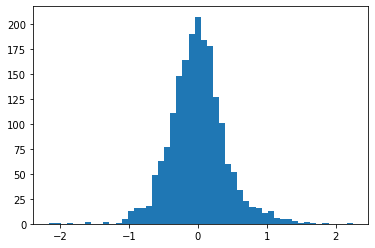

In [22]:
plt.hist(model.resid, bins=50)
plt.show()

### Model without the topics included

In [23]:
model_without_topics = sm.ols("logPRICE ~ logAREA + logLOTSIZE + BED + BATH + BUILT", data=ct_topics).fit()
model_without_topics.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     1417.
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:56:47   Log-Likelihood:                -1370.4
No. Observations:                1926   AIC:                             2753.
Df Residuals:                    1920   BIC:                             2786.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9172      0.528     11.203      0.000       4.881       6.953
logAREA        0.7285      0.035     20.723      0.000       0.660       0.797
logLOTSIZE     0.0673      0.010      6.481      0.000       0.047       0.088
BED           -0.0620      0.015     -4.214      0.000      -0.091      -0.033
BATH           0.2373      0.011     21.734      0.000       0.216       0.259
BUILT          0.0006      0.000      2.249      0.025    7.19e-05       0.001
==============================================================================
Omnibus:                      271.078   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              863.510
Skew:                           0.705   Prob(JB):                    3.10e-188
Kurtosis:                       5.961   Cond. No.                     9.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Plot the residuals

On a single plot, show a histogram of the residuals of the model without the topics, 
and the residuals of the model with the topics. Give a legend that shows which is which.
Comment on the results. 


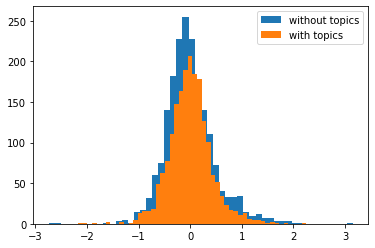

In [24]:
plt.hist(model_without_topics.resid, bins=50, label='without topics')
plt.hist(model.resid, bins=50, label='with topics')
plt.legend()
plt.show()

#### Quantify the improvement

What is the percent decrease in the mean-squared-error of the model with the topics
compared to the model that ignores the descriptions?


In [25]:
#percent decrease of the mean-squared-error by using the description
100*(model_without_topics.mse_resid - model.mse_resid)/model_without_topics.mse_resid

28.998458429784076

### Repeat for three topics 

Now, repeat the above steps for a topic model that is trained using only three (3) topics. Specifically:

1. Train a model with three topics
1. Display the top words in each of the three topics
1. Augment the `ct_homes` data with the resulting topic proportions
1. Fit a linear model *using only two of the three* proportions
1. Comment on the improvement over the baseline in terms of R squared.
1. Plot a histogram of the residuals
1. Quantify the improvement in the MSE

In [26]:
tm3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=3, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

topics = pd.DataFrame({"Topic0": np.zeros(ct_homes.shape[0])})
for t in range(1,3):
    topics["Topic"+str(t)] = np.zeros(ct_homes.shape[0])
    
for i in range(ct_homes.shape[0]):
    for t in tm3.get_document_topics(corpus[i]):
        topics.loc[i,"Topic"+str(t[0])] = t[1]


In [27]:
ct_3topics = ct_homes.join(topics)


In [28]:
num_topics = 3
num_words = 25
top_words = pd.DataFrame({'word rank': np.arange(1,num_words+1)})
for k in np.arange(num_topics): 
    topic = tm3.get_topic_terms(k, num_words)
    words = [id2word[topic[i][0]] for i in np.arange(num_words)]
    probs = [topic[i][1] for i in np.arange(num_words)]
    top_words['topic %d' % k] = words

top_words

,word rank,topic 0,topic 1,topic 2
0,1,views,property,spacious
1,2,beach,it,additional
2,3,island,will,main
3,4,suite,can,appliances
4,5,custom,located,throughout
5,6,by,are,lower
6,7,sound,at,yard
7,8,pool,one,beautiful
8,9,waterfront,own,bathroom
9,10,stone,location,granite


In [29]:
ct_3topics

,AREA,BED,BATH,BUILT,DESCRIPTION,LOTSIZE,PRICE,logAREA,logLOTSIZE,logPRICE,Topic0,Topic1,Topic2
0,1629.0,2.0,2.0,1889.0,"Welcome home! Charming & well kept, this 2 bed...",0.159986,224000.0,7.395722,-1.832669,12.319401,0.056841,0.341714,0.601445
1,1278.0,3.0,2.0,1900.0,This adorable cape has a lot to offer. You st...,0.179981,225000.0,7.153052,-1.714902,12.323856,0.000000,0.288070,0.704741
2,1264.0,3.0,2.0,1988.0,This 1264 sqft Colonial with its 3 bedrooms an...,0.089991,224900.0,7.142037,-2.408049,12.323411,0.000000,0.878320,0.116558
3,2054.0,3.0,3.0,1960.0,The perfect oversized ranch awaits you at 7 No...,0.569994,370000.0,7.627544,-0.562129,12.821258,0.000000,0.066717,0.930361
4,4198.0,5.0,3.0,1972.0,Beautiful Colonial-3020 sqft. living space and...,0.939989,489999.0,8.342364,-0.061887,13.102159,0.000000,0.204541,0.790525
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1921,848.0,3.0,2.0,1948.0,This home sets at the beginning of a Cul-de-Sa...,0.189990,429900.0,6.742881,-1.660781,12.971308,0.000000,0.216589,0.777545
1922,2400.0,4.0,4.0,2021.0,New home to be built. Amazing unobstructed wat...,0.079981,800000.0,7.783224,-2.525960,13.592367,0.334038,0.018248,0.647714
1923,6538.0,7.0,7.0,2002.0,Can you say water views galore? Wake up to the...,0.079981,2700000.0,8.785387,-2.525960,14.808762,0.406170,0.579553,0.014277
1924,4480.0,5.0,5.0,1890.0,NEW YEAR! NEW FUTURE! Escape NY to Connect...,0.849998,2550000.0,8.407378,-0.162521,14.751604,0.394665,0.588742,0.016593


In [30]:
model_3topics = sm.ols("logPRICE ~ logAREA + logLOTSIZE + BED + BATH + BUILT + Topic0 + Topic2", data=ct_3topics).fit()
model_3topics.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logPRICE   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1758.
Date:                Wed, 10 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:56:55   Log-Likelihood:                -928.83
No. Observations:                1926   AIC:                             1874.
Df Residuals:                    1918   BIC:                             1918.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.4417      0.434     14.843      0.000       5.591       7.293
logAREA        0.4100      0.030     13.548      0.000       0.351       0.469
logLOTSIZE     0.0262      0.008      3.132      0.002       0.010       0.043
BED            0.0039      0.012      0.328      0.743      -0.019       0.027
BATH           0.1164      0.009     12.274      0.000       0.098       0.135
BUILT          0.0013      0.000      6.589      0.000       0.001       0.002
Topic0         2.2169      0.069     32.164      0.000       2.082       2.352
Topic2         0.2019      0.038      5.273      0.000       0.127       0.277
==============================================================================
Omnibus:                      143.522   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.860
Skew:                           0.283   Prob(JB):                    4.36e-117
Kurtosis:                       5.521   Cond. No.                     9.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation

Now, interpret the model. Use the coefficients of the linear model to 
help interpret the meaning of the topics. Comment on what this says 
about the effectiveness of the topic model for predicting the sale price 
of the house. Does it make intuitive sense? Why or why not?


#### Interpretation 

It appears from the model that the second two topics have to do with just the basic necessities of a home. Whereas the first topic is about add-on luxuries! And the linear model suggests that the less frequently this first topic is used in the description, the more the price will drop. In fact, since the t-score of the coefficient for this topic 
is the largest in the model. This suggests that the mention of luxuries in the description has a greater influence on the price than the other variables.

We find that the topics are a statistically-significant set of variables in predicting the price of houses sold in Connecticut! Furthermore, the dimensionally-reduced description appears to have a greater influence on the price than internal area, lot size, bedroom count, bathroom count, and year built. Read before you buy!